# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.2)


In [2]:
!pip install -U xgboost

  Using cached https://files.pythonhosted.org/packages/c4/04/32989ec64004dca894f1d3ea4c41b1397272857edf14c1a9d1492b692d2d/xgboost-1.5.2.tar.gz
  Running setup.py bdist_wheel for xgboost ... error
  Complete output from command /opt/conda/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-fq8yc5k3/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-j04th4_s --python-tag cp36:
  /opt/conda/lib/python3.6/distutils/dist.py:261: UserWarning: Unknown distribution option: 'long_description_content_type'
    warnings.warn(msg)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.6
  creating build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/compat.py -> build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/__init__.py -> build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/sklearn.py -> buil

In [3]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Data Understanding


### 1.1 Portfolio data set

In [4]:
#get an overview over the data and its structure
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [8]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### 1.2 Profile data set

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.shape

(17000, 5)

In [11]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [12]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [13]:
# fill missing income numbers with the mean
profile['income'].fillna(profile['income'].mean(), inplace=True)

In [14]:
# remove missing gender rows because I cant fill it with a mean or something else
profile['gender'].dropna(inplace=True)


In [15]:
profile[profile.isnull().any(axis=1)]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,65404.991568
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,65404.991568
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,65404.991568
10,118,20170824,None,c4863c7985cf408faee930f111475da3,65404.991568
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,65404.991568
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,65404.991568
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,65404.991568


### 1.3 Transcript data set

In [16]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
transcript.shape

(306534, 4)

In [18]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [19]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [20]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

### 1.4 Summary

It seems like the data needs some pre processing and contains a lot of data. There are almost no null/ nan values apart from in the gender and income fields of the profile data set. It seems like all the null values for gender and income are corresponding to rows with an age of 118 - this might be a data issue and we can drop these rows as they wont be useful for modeling.


The next stept will be covering the data pre-processing.

## 2. Data Cleaning / Pre-processing


In this step we will clean and pre-process the data.

### 2.1 Portfolio data set

In [21]:
#Change the access channels into different columns for better encoding
port=portfolio
port['email'] = port['channels'].apply(lambda x: 1 if 'email' in x else 0)
port['social'] = port['channels'].apply(lambda x: 1 if 'social' in x else 0)
port['web'] = port['channels'].apply(lambda x: 1 if 'web' in x else 0)
port['mobile'] = port['channels'].apply(lambda x: 1 if 'mobile' in x else 0)

pd.get_dummies(port, columns=['offer_type'], drop_first=True)


# Rename and drop columns clearly
port.rename(columns={'id':'portfolio_id'}, inplace=True)

port.drop(columns=['offer_type', 'channels'], inplace=True)

In [22]:
port.head()

,difficulty,duration,portfolio_id,reward,email,social,web,mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,1,0


Text(0.5, 0, 'Reward')

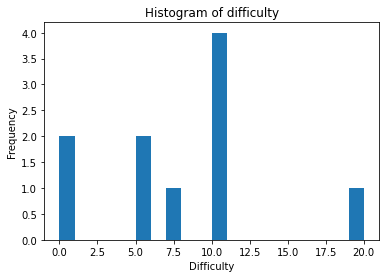

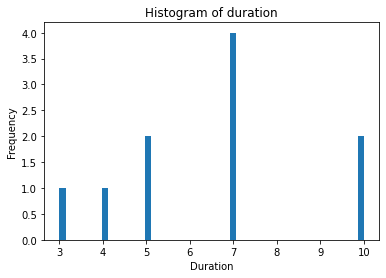

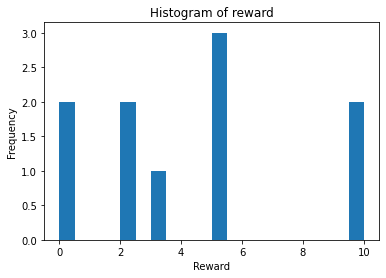

In [23]:
# display histogram of customers age
difficulty = port['difficulty'].plot(kind='hist', bins=20, title='Histogram of difficulty')
difficulty.set_xlabel("Difficulty")

# histogram of number of days a profile has been customer since
plt.figure()
duration = port['duration'].plot(kind='hist', bins=50, title='Histogram of duration')
duration.set_xlabel("Duration")

# histogram of the income
plt.figure()
reward = port['reward'].plot(kind='hist', bins=20, title='Histogram of reward')
reward.set_xlabel("Reward")

### 2.2 Profile data set

In [24]:
## drop rows with age 118 and missing values
prof = profile[profile.age != 118]
prof.dropna(inplace=True)

## convert the membersince column from string to date format
prof['became_member_on'] = pd.to_datetime(prof['became_member_on'], format='%Y%m%d')

## get number of days a person has been a member since
prof['days_member'] = pd.Timestamp.now().normalize()  - prof['became_member_on']
prof["days_member"]=prof["days_member"].dt.days



prof.rename(columns={'id':'profile_id'}, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [25]:
# get dummies for gender
g = prof['gender']
prof = pd.get_dummies(prof, columns=['gender'])
prof['gender'] = g

In [26]:
prof.head()

,age,became_member_on,profile_id,income,days_member,gender_F,gender_M,gender_O,gender
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2390,1,0,0,F
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2457,1,0,0,F
5,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,2105,0,1,0,M
8,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,2181,0,1,0,M
12,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2271,0,1,0,M


Text(0.5, 0, 'Income')

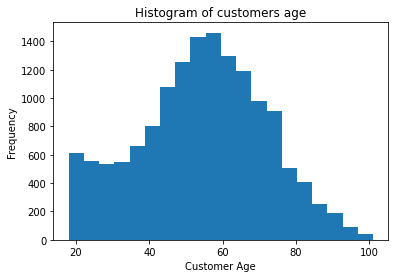

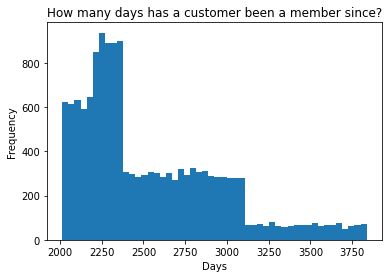

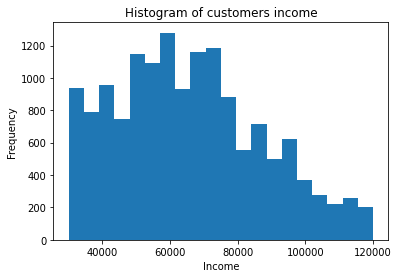

In [27]:
# display histogram of customers age
user_age = prof['age'].plot(kind='hist', bins=20, title='Histogram of customers age')
user_age.set_xlabel("Customer Age")

# histogram of number of days a profile has been customer since
plt.figure()
memberdays = prof['days_member'].plot(kind='hist', bins=50, title='How many days has a customer been a member since?')
memberdays.set_xlabel("Days")

# histogram of the income
plt.figure()
user_income = prof['income'].plot(kind='hist', bins=20, title='Histogram of customers income')
user_income.set_xlabel("Income")

## 2.3 Transcript data set

In [28]:
# extract the rows that are related to offer action 
#trans = transcript[transcript['value'].str.contains(r'offer ?id')]
trans = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]

# extract the offer id from value column
trans['offer_id'] = trans['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

trans.rename(columns={'person':'profile_id'}, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [29]:
# create an encoding for a label to predict later as y
trans['event'] = trans['event'].map({'offer completed': 1, 'offer viewed': 0, 'offer received': 0})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
trans.head()

,event,profile_id,time,value,offer_id
0,0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,0,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,0,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,0,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [31]:
trans['event'].unique()

array([0, 1])

In [32]:
trans['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

## 2.4 Merging the data sets 

In [33]:
port.head()

,difficulty,duration,portfolio_id,reward,email,social,web,mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,1,0


In [34]:
pt = pd.merge(prof, trans, on='profile_id', how="right")

df = pd.merge(pt, port, left_on='offer_id', right_on='portfolio_id')



# Since the offer ids are restricted to 10 ids we can change
#them to a simpler version for clarity
ids = {'ae264e3637204a6fb9bb56bc8210ddfd': '0',
            '4d5c57ea9a6940dd891ad53e9dbe8da0': '1',
            '9b98b8c7a33c4b65b9aebfe6a799e6d9': '2',
            'f19421c1d4aa40978ebb69ca19b0e20d': '3',
            '0b1e1539f2cc45b7b9fa7c272da2e1d7': '4',
            '2298d6c36e964ae4a3e7e9706d1fb8c2': '5',
            'fafdcd668e3743c1bb461111dcafc2a4': '6',
            '2906b810c7d4411798c6938adc9daaa5': '7',
            '3f207df678b143eea3cee63160fa8bed': '8',
            '5a8bc65990b245e5a138643cd4eb9837': '9'}
df.offer_id = df.offer_id.apply(lambda x: ids[x] if x else None)



In [35]:
df.head()

,age,became_member_on,profile_id,income,days_member,gender_F,gender_M,gender_O,gender,event,...,value,offer_id,difficulty,duration,portfolio_id,reward,email,social,web,mobile
0,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2390.0,1.0,0.0,0.0,F,0,...,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2390.0,1.0,0.0,0.0,F,1,...,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,2,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1
2,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2457.0,1.0,0.0,0.0,F,0,...,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2457.0,1.0,0.0,0.0,F,0,...,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1
4,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2457.0,1.0,0.0,0.0,F,1,...,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,2,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1


## 2.5 Visualisations

In [36]:
def plot_profile(df, variable):
    """
    Creates a clear and concise histogram and density plot for a variable,
    stratified by gender.

    Args:
        df (pandas.DataFrame): DataFrame containing the variable to plot.
        variable (str): Name of the variable to plot.

    Returns:
        matplotlib.pyplot.figure: Figure object containing the plot.
    """

    sns.set_style("whitegrid")
    palette = sns.color_palette()

    fig, axes = plt.subplots(figsize=(15, 4), ncols=3, sharex=True, sharey=True)
    genders = ['F', 'M', 'O']

    for gender, ax in zip(genders, axes):
        sns.histplot(
            data=df[df["gender"] == gender],
            x=variable,
            kde=True,  # Combine histogram and density plot for clarity
            color=palette[genders.index(gender)],
            ax=ax,
            bins=10,
        )
        ax.set_title(f"{gender}'s {variable.title()} Distribution")
        ax.set_xlabel(variable.title())  # Capitalize for readability
        ax.set_ylabel("Distribution")

    plt.tight_layout()  # Adjust spacing for better readability
    return fig


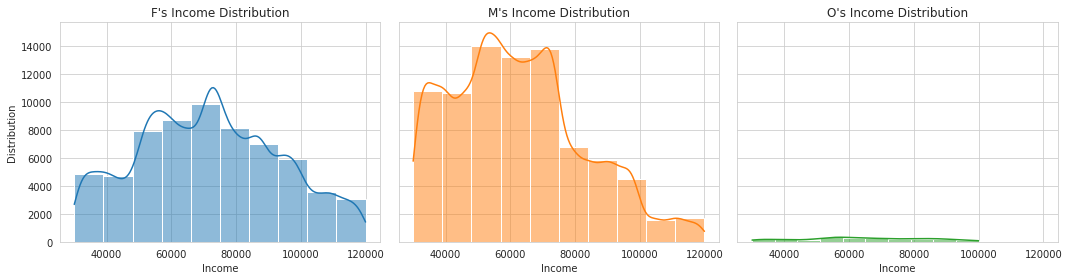

In [37]:
age_plot = plot_profile(df, 'income')

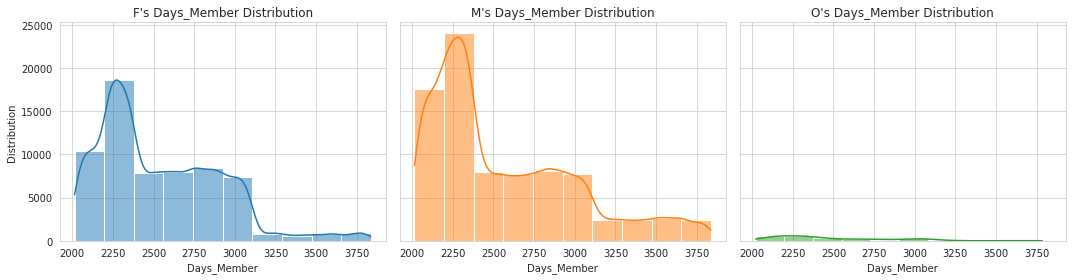

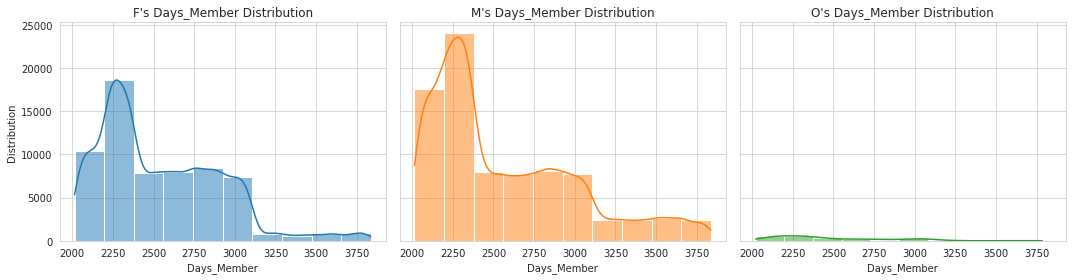

In [38]:
plot_profile(df, 'days_member')

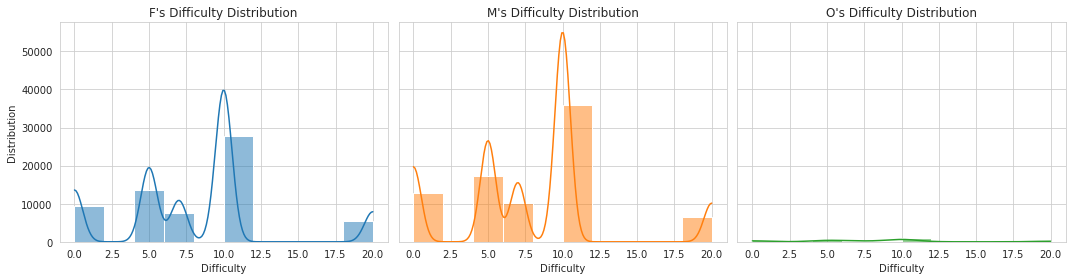

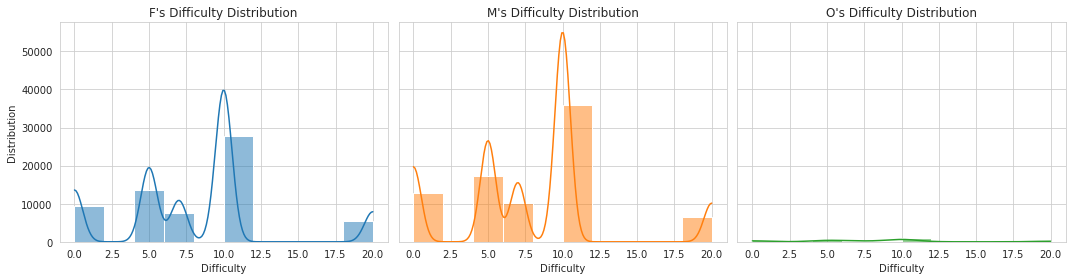

In [39]:
plot_profile(df, 'difficulty')

In [40]:
df['age'].value_counts(normalize=True)

58.0     0.028406
53.0     0.025456
57.0     0.024919
51.0     0.024515
59.0     0.024394
55.0     0.024381
54.0     0.024146
52.0     0.024058
56.0     0.023561
63.0     0.023474
60.0     0.023003
49.0     0.022042
62.0     0.021908
64.0     0.021572
67.0     0.021269
61.0     0.021014
48.0     0.019327
50.0     0.019260
65.0     0.019119
66.0     0.019032
68.0     0.017903
70.0     0.017190
69.0     0.016733
45.0     0.015719
71.0     0.015456
47.0     0.015309
42.0     0.014690
46.0     0.014650
43.0     0.014590
73.0     0.014233
           ...   
35.0     0.008246
19.0     0.008232
20.0     0.008152
81.0     0.008131
22.0     0.008058
23.0     0.008051
29.0     0.007762
79.0     0.007627
83.0     0.007191
31.0     0.007076
82.0     0.006989
84.0     0.005705
85.0     0.004980
18.0     0.004489
87.0     0.004429
88.0     0.004368
86.0     0.003817
89.0     0.003629
90.0     0.003293
91.0     0.003051
92.0     0.002910
94.0     0.002413
93.0     0.002023
95.0     0.001411
97.0     0

<AxesSubplot:xlabel='difficulty'>

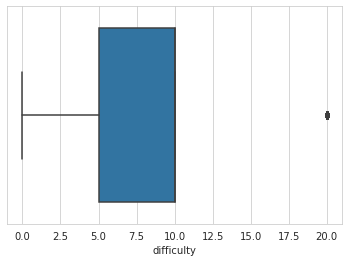

In [41]:
sns.boxplot(data=df,x='difficulty')

<AxesSubplot:xlabel='event', ylabel='count'>

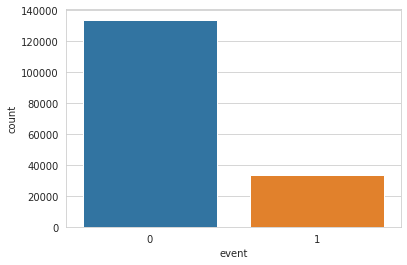

In [42]:
sns.countplot(data=df, x="event")

## 2.6 Conclusing/ Findings

1. Male customers had a higher income distribution especially in the middle field of the income distribution.
2. Female customers age distribution is almost normal distributed while the distribution of male customers age is right skewed.
3. Both female and male customers have been customers for 2000-2500 days.
4. Both female and male customers have a very similar difficulty distribution.
5. Most offers were viewed but only around a third was completed.


## 3. Modelling

Assign training and label data. For Y I will be using a flag for whether a offer was completed.

In [43]:
data = df.dropna(how='any')

In [44]:
X = data[['age', 'income', 'days_member', 'time', 'difficulty', 'duration', 'reward',
     'email', 'social', 'web', 'mobile', 'gender_F',
     'gender_M', 'gender_O']]
y =  data['event']

In [45]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: event, dtype: int64

In [46]:
X = X.astype(np.float64)

In [47]:
X.isnull().any()

age            False
income         False
days_member    False
time           False
difficulty     False
duration       False
reward         False
email          False
social         False
web            False
mobile         False
gender_F       False
gender_M       False
gender_O       False
dtype: bool

## 3.1 Scaling the data

Scaling the data using min max scaler by sklearn.

In [48]:
s = MinMaxScaler()
cols = list(X.columns)

X[cols] = s.fit_transform(X[cols])

## 3.2 Splitting the data

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 5)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 99699 rows
Testing set: 49106 rows


## 3.3 Random Forest Classifier

In [50]:


def train_rf_model(X_train, y_train, X_test, y_test):
    """
    Trains a Random Forest classifier, evaluates its performance, prints results,
    and returns accuracy and F1 score.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        Training data features.
    y_train : array-like of shape (n_samples,)
        Training data labels.
    X_test : array-like of shape (n_samples, n_features)
        Test data features.
    y_test : array-like of shape (n_samples,)
        Test data labels.

    Returns
    -------
    accuracy : float
        Accuracy score of the model on the test set.
    f1_score : float
        F1 score of the model on the test set.
    """

    start_time = time.time()
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    total_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling:", total_time)

    # Create DataFrame with a row of values
    rf = pd.DataFrame([[accuracy, f1]], columns=['acc', 'f1'])  
    return rf


In [51]:
rf = train_rf_model(X_train, y_train, X_test, y_test)

Accuracy: 73.93%
F1-Score: 0.23921568627450984
Total Time Spent Modeling: 1.5827357769012451


In [52]:
rf

,acc,f1
0,0.739258,0.239216


## 3.4 Naive Bayes - Gaussian NB

In [53]:
def train_nb_model(X_train, y_train, X_test, y_test):
    """
    Trains a Naive Bayes classifier, evaluates its performance, prints results,
    and returns accuracy and F1 score.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        Training data features.
    y_train : array-like of shape (n_samples,)
        Training data labels.
    X_test : array-like of shape (n_samples, n_features)
        Test data features.
    y_test : array-like of shape (n_samples,)
        Test data labels.

    Returns
    -------
    accuracy : float
        Accuracy score of the model on the test set.
    f1_score : float
        F1 score of the model on the test set.
    """

    start_time = time.time()
    
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    total_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling:", total_time)

    # Create DataFrame with a row of values
    nb = pd.DataFrame([[accuracy, f1]], columns=['acc', 'f1'])  
    return nb


In [54]:
nb = train_nb_model(X_train, y_train, X_test, y_test)

Accuracy: 74.07%
F1-Score: 0.23160943817512525
Total Time Spent Modeling: 0.02480173110961914


In [55]:
nb

,acc,f1
0,0.740704,0.231609


## 3.5 Ada Boost

In [56]:
def train_adaboost_model(X_train, y_train, X_test, y_test):
    """
    Trains a Ada Boost classifier, evaluates its performance, prints results,
    and returns accuracy and F1 score.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        Training data features.
    y_train : array-like of shape (n_samples,)
        Training data labels.
    X_test : array-like of shape (n_samples, n_features)
        Test data features.
    y_test : array-like of shape (n_samples,)
        Test data labels.

    Returns
    -------
    accuracy : float
        Accuracy score of the model on the test set.
    f1_score : float
        F1 score of the model on the test set.
    """
    
    start_time = time.time()
    
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    total_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling:", total_time)

    # Create DataFrame with a row of values
    ada = pd.DataFrame([[accuracy, f1]], columns=['acc', 'f1'])  
    return ada


In [57]:
ada = train_adaboost_model(X_train, y_train, X_test, y_test)

Accuracy: 80.94%
F1-Score: 0.41441441441441446
Total Time Spent Modeling: 3.8352832794189453


In [58]:
ada

,acc,f1
0,0.809392,0.414414


## 3.6 MLP Classifier

In [59]:


def train_mlp_model(X_train, y_train, X_test, y_test):
    """
    Trains a MLP classifier, evaluates its performance, prints results,
    and returns accuracy and F1 score.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        Training data features.
    y_train : array-like of shape (n_samples,)
        Training data labels.
    X_test : array-like of shape (n_samples, n_features)
        Test data features.
    y_test : array-like of shape (n_samples,)
        Test data labels.

    Returns
    -------
    accuracy : float
        Accuracy score of the model on the test set.
    f1_score : float
        F1 score of the model on the test set.
    """
    
    start_time = time.time()
    
    model = MLPClassifier(max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    total_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling:", total_time)

    # Create DataFrame with a row of values
    mlp = pd.DataFrame([[accuracy, f1]], columns=['acc', 'f1'])  
    return mlp


In [60]:
mlp = train_mlp_model(X_train, y_train, X_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy: 78.44%
F1-Score: 0.041470481709525525
Total Time Spent Modeling: 228.0062038898468


In [61]:
mlp

,acc,f1
0,0.784426,0.04147


## 3.7 SVC Classifier

In [62]:
def train_svc_model(X_train, y_train, X_test, y_test):
    """
    Trains a SVC classifier, evaluates its performance, prints results,
    and returns accuracy and F1 score.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        Training data features.
    y_train : array-like of shape (n_samples,)
        Training data labels.
    X_test : array-like of shape (n_samples, n_features)
        Test data features.
    y_test : array-like of shape (n_samples,)
        Test data labels.

    Returns
    -------
    accuracy : float
        Accuracy score of the model on the test set.
    f1_score : float
        F1 score of the model on the test set.
    """
    
    start_time = time.time()
    
    model = LinearSVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    total_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling:", total_time)


    # Create DataFrame with a row of values
    svc = pd.DataFrame([[accuracy, f1]], columns=['acc', 'f1'])  
    return svc

In [63]:
svc = train_svc_model(X_train, y_train, X_test, y_test)

Accuracy: 78.18%
F1-Score: 0.0013049962714392243
Total Time Spent Modeling: 3.652458429336548


In [64]:
svc

,acc,f1
0,0.781819,0.001305


## 4. Model metrics comparison

In [65]:
rf['acc'][0]

0.7392579318209588

In [66]:
dict_scores = {'Classifier':['Random Forest', 'Gaussian NB', 'Ada Boost', 'MLP', 'SVC'],
               'Accuracy': [rf['acc'][0], nb['acc'][0], ada['acc'][0], mlp['acc'][0], svc['acc'][0]],
               'F1':[rf['f1'][0], nb['f1'][0], ada['f1'][0], mlp['f1'][0], svc['f1'][0]]}
scores = pd.DataFrame(dict_scores)  
scores['Accuracy'] = scores['Accuracy'].astype(float)

In [67]:
scores

,Classifier,Accuracy,F1
0,Random Forest,0.739258,0.239216
1,Gaussian NB,0.740704,0.231609
2,Ada Boost,0.809392,0.414414
3,MLP,0.784426,0.041470
4,SVC,0.781819,0.001305


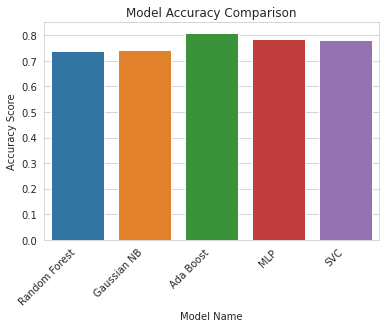

In [68]:
# Create a bar plot
sns.barplot(x='Classifier', y='Accuracy', data=scores)

# Customize the plot
plt.title('Model Accuracy Comparison')
plt.xlabel('Model Name')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

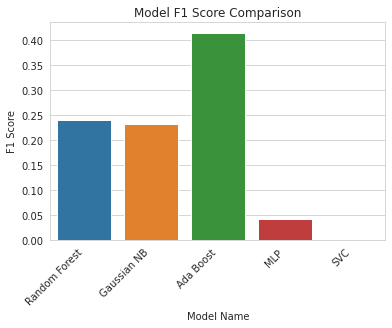

In [69]:
# Create a bar plot
sns.barplot(x='Classifier', y='F1', data=scores)

# Customize the plot
plt.title('Model F1 Score Comparison')
plt.xlabel('Model Name')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

## 4.1 Conclusion

Across both the accuracy and F1 score, AdaBoost performs the best. This is likely due to its ensemble technique nature which is a great one fits all approach and works well with imbalanced data sets.
The next step will try to 

## 4.2 Grid Search / Hyperparameter Tuning

In [70]:


# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Create AdaBoost classifier
adaboost = AdaBoostClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best estimator
best_clf = grid_search.best_estimator_

# Evaluate best model on test set
print("Best parameters:", grid_search.best_params_)
print("Best score on test set:", best_clf.score(X_test, y_test))

Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}
Best score on test set: 0.8314869873335234


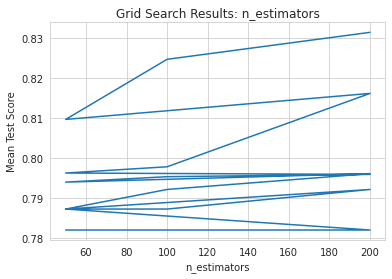

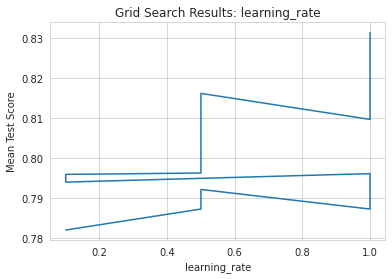

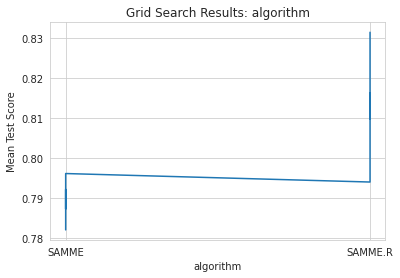

In [71]:
# Extract results
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']

# Create a plot for each hyperparameter
for param_name in param_grid:
    plt.figure()
    plt.title("Grid Search Results: " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("Mean Test Score")

    # Extract values for the current hyperparameter
    param_values = [x[param_name] for x in params]

    # Plot mean test scores for each value
    plt.plot(param_values, mean_test_scores)
    plt.show()

Run the ada function again with the best parameters.

In [72]:
def train_improved_adaboost_model(X_train, y_train, X_test, y_test):
    """
    Trains a Ada Boost classifier, evaluates its performance, prints results,
    and returns accuracy and F1 score.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        Training data features.
    y_train : array-like of shape (n_samples,)
        Training data labels.
    X_test : array-like of shape (n_samples, n_features)
        Test data features.
    y_test : array-like of shape (n_samples,)
        Test data labels.

    Returns
    -------
    accuracy : float
        Accuracy score of the model on the test set.
    f1_score : float
        F1 score of the model on the test set.
    """
    
    start_time = time.time()
    
    model = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 1.0, n_estimators= 200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    total_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("F1-Score:", f1)
    print("Total Time Spent Modeling:", total_time)

    # Create DataFrame with a row of values
    ada = pd.DataFrame([[accuracy, f1, model]], columns=['acc', 'f1', 'model'])  
    return ada


In [73]:
ada_improved = train_improved_adaboost_model(X_train, y_train, X_test, y_test)

Accuracy: 83.15%
F1-Score: 0.5851090498871898
Total Time Spent Modeling: 15.372131586074829


In [74]:
dict_scores = {'Classifier':['Random Forest', 'Gaussian NB', 'Ada Boost', 'MLP', 'SVC', 'Ada Boost Improved'],
               'Accuracy': [rf['acc'][0], nb['acc'][0], ada['acc'][0], mlp['acc'][0], svc['acc'][0], ada_improved['acc'][0]],
               'F1':[rf['f1'][0], nb['f1'][0], ada['f1'][0], mlp['f1'][0], svc['f1'][0], ada_improved['f1'][0]]}
scores = pd.DataFrame(dict_scores)  
scores['Accuracy'] = scores['Accuracy'].astype(float)

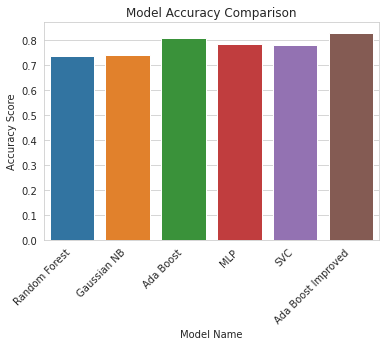

In [75]:
# Create a bar plot
sns.barplot(x='Classifier', y='Accuracy', data=scores)


plt.title('Model Accuracy Comparison')
plt.xlabel('Model Name')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45, ha='right')  
plt.show()

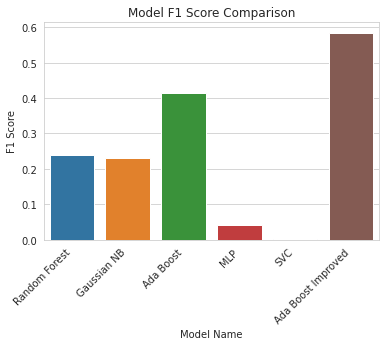

In [76]:
# Create a bar plot
sns.barplot(x='Classifier', y='F1', data=scores)

plt.title('Model F1 Score Comparison')
plt.xlabel('Model Name')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right') 
plt.show()

## 5. Feature Analysis

In [77]:
ada_improved.head()

,acc,f1,model
0,0.831487,0.585109,"(DecisionTreeClassifier(class_weight=None, cri..."


        Feature  Importance
3          time       0.890
1        income       0.045
2   days_member       0.025
0           age       0.010
5      duration       0.010
4    difficulty       0.005
6        reward       0.005
9           web       0.005
12     gender_M       0.005
7         email       0.000
8        social       0.000
10       mobile       0.000
11     gender_F       0.000
13     gender_O       0.000


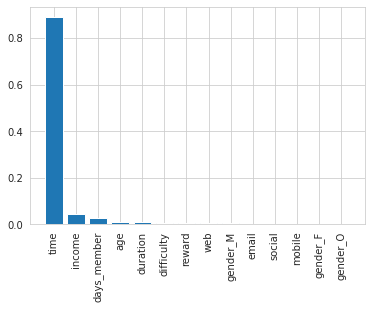

In [78]:
# Access feature importances
feature_importances = ada_improved['model'][0].feature_importances_

# Get feature names
feature_names = pd.DataFrame(X_train).columns  # Assuming features are in a DataFrame X_train

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print or visualise the feature importances
print(feature_importances_df)


plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xticks(rotation=90)  
plt.show()

## 6. Conclusion

It can be concluded that AdaBoost performed the best in this scenario. Especially, with the performed hyperparameter tuning and the improved parameters.

The features most important for this run seem to be time by a significant amount, and also income and the days a customer has been a member since. From a company's point of view, these features should be taken as important for future processes.